In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import deep_fib

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Hyperparameters

In [3]:
log_dir = "./final/deep_fib_sim_2"

horizon = 1024
stride = 512

batch_size = 32

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

n_masks = 10
loss_type = "l1"
mask_value = -1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.MINMAX)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.MINMAX)


Loading: 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
base_width = 128
down_layers = 2
dilations = [False, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)
model = simple_conv.SimpleSegConv(backbone, data.NUM_FEATURES)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = deep_fib.DeepFIBEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
    mask_value=mask_value,
    masks=deep_fib.get_masks(horizon, n_masks).float(),
    loss_type=loss_type,
)


# Training

In [20]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss=0.053 - test_loss=0.096 - cost=0.198 - threshold=0.149 - lr=1.00e-03


Epoch 1 - train_loss=0.045 - test_loss=0.088 - cost=0.198 - threshold=0.132 - lr=9.76e-04


Epoch 2 - train_loss=0.042 - test_loss=0.088 - cost=0.200 - threshold=0.129 - lr=9.05e-04


Epoch 3 - train_loss=0.038 - test_loss=0.081 - cost=0.200 - threshold=0.116 - lr=7.94e-04


Epoch 4 - train_loss=0.037 - test_loss=0.086 - cost=0.199 - threshold=0.120 - lr=6.55e-04


Epoch 5 - train_loss=0.039 - test_loss=0.080 - cost=0.199 - threshold=0.115 - lr=5.00e-04


Epoch 6 - train_loss=0.037 - test_loss=0.075 - cost=0.199 - threshold=0.108 - lr=3.45e-04


Epoch 7 - train_loss=0.035 - test_loss=0.078 - cost=0.199 - threshold=0.110 - lr=2.06e-04


Epoch 8 - train_loss=0.035 - test_loss=0.085 - cost=0.200 - threshold=0.119 - lr=9.55e-05


Epoch 9 - train_loss=0.035 - test_loss=0.081 - cost=0.199 - threshold=0.112 - lr=2.45e-05


# Evaluating

In [8]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [9]:
# Cost model
cmodel = metrics.default_cmodel()


In [10]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 21/21 [00:06<00:00,  3.21it/s]


In [11]:
cmodel.fit(scores, labels).optimize()


(0.11237870603799827, 0.1991795)

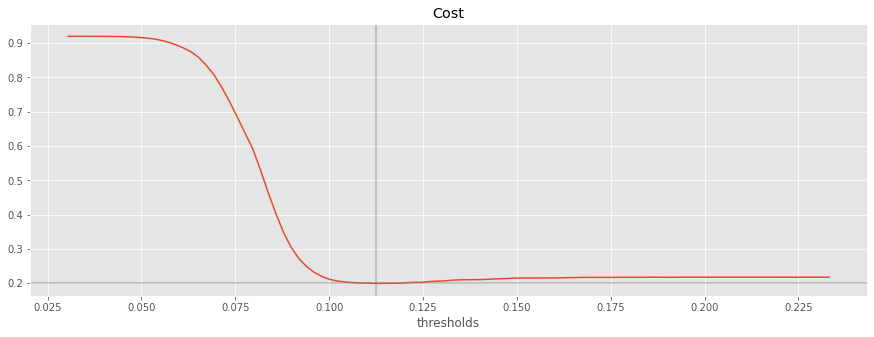

In [12]:
metrics.plot_cost(cmodel)


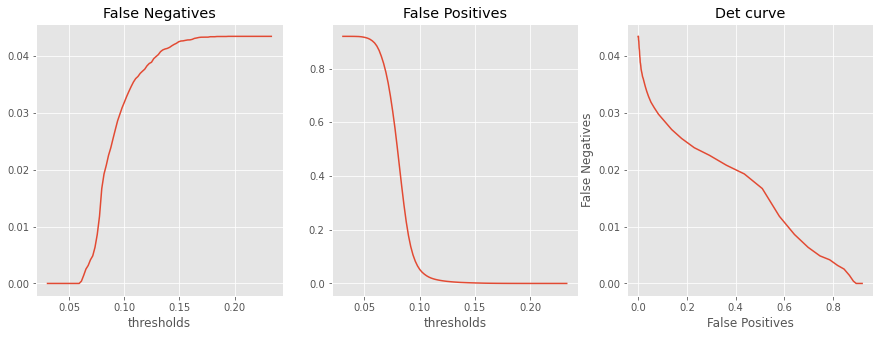

In [13]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


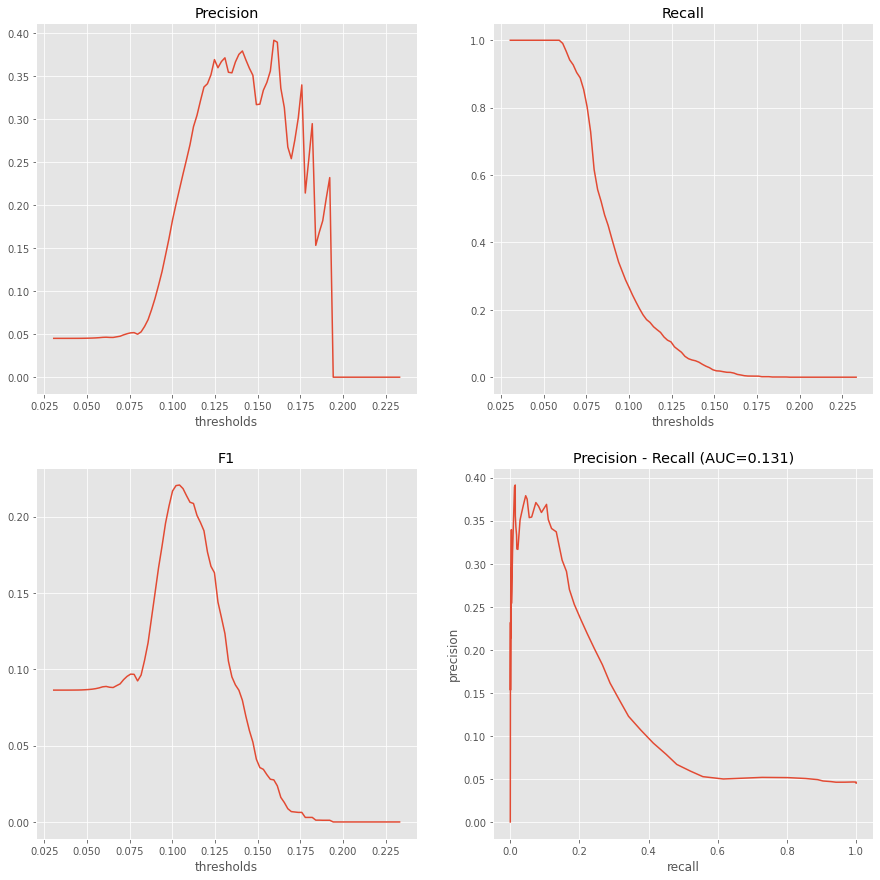

In [14]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)

In [15]:
batch = next(iter(test_loader))


In [16]:
for l, d in batch.items():
    print(l, d.size())

data torch.Size([32, 1024, 460])
label torch.Size([32, 1024])


In [17]:
inputs = batch["data"]
inputs = inputs.to(device)
targets = inputs.detach().clone()

model.eval()
preds = engine._get_preds(inputs)

errors = deep_fib.residual_error(preds, targets)
labs = (errors > 0.11237870603799827).int()

In [35]:
errors.size()

torch.Size([32, 1024])

In [31]:
idx = 20

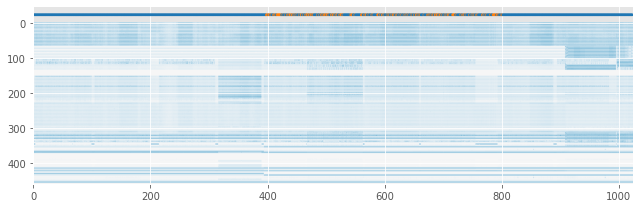

In [32]:
from common.nn import plot_dataframe, pd

plot_dataframe(pd.DataFrame(batch["data"][idx]), labels=pd.Series(batch["label"][idx]))

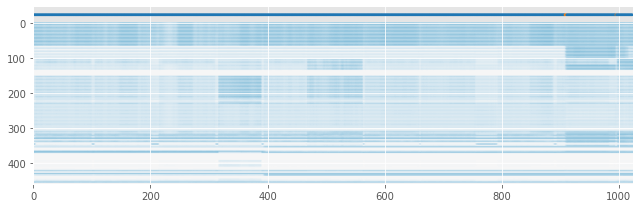

In [33]:
plot_dataframe(pd.DataFrame(preds[idx].detach().cpu().numpy()), labels=pd.Series(labs[idx].detach().cpu().numpy()))